<a href="https://colab.research.google.com/github/tranlg99/L4_project/blob/main/src/colab_notebooks/frame_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frame reconstruction using NearestNDInterpolator

## Imports and helper functions

In [3]:
# connecting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from datetime import date
import torchvision
import numpy as np
import torch
import argparse
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import torch.nn as nn
from collections import OrderedDict
import torch.optim as optim
import time
import copy
import torchvision.transforms as transforms
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import matplotlib.pyplot as plt

import sys
sys.path.append('/content/drive/My Drive/drive_folder')
from custom_dataset_loader import TaiChiDataset, ToTensor, Normalize
from helper_functions import set_parameter_requires_grad, meshgrid2d, get_grid, plot_learning_curve, split_dataset, initialise_model, get_predictions

In [22]:
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def show_coords(true_c, true_v):
  true_v = true_v <= 0
  plt.scatter(true_c[:, 0], true_c[:, 1], s=0.5, marker='.', c=true_v, cmap=plt.cm.coolwarm)
  plt.ylim(360, 0)
  plt.title('True Coords')
  plt.show()


In [13]:
def meshgrid2d(B, Y, X, stack=False):
    # returns a meshgrid sized B x Y x X

    grid_y = torch.linspace(0.0, Y-1, Y)
    grid_y = torch.reshape(grid_y, [1, Y, 1])
    grid_y = grid_y.repeat(B, 1, X)

    grid_x = torch.linspace(0.0, X-1, X)
    grid_x = torch.reshape(grid_x, [1, 1, X])
    grid_x = grid_x.repeat(B, Y, 1)

    if stack:
        # note we stack in xy order
        # (see https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.grid_sample)
        grid = torch.stack([grid_x, grid_y], dim=-1)
        return grid
    else:
        return grid_y, grid_x

def get_grid(N, B, H, W, normalise=False):
  N_ = np.sqrt(N).round().astype(np.int32)
  grid_y, grid_x = meshgrid2d(B, N_, N_, stack=False)
  grid_y = 8 + grid_y.reshape(B, -1)/float(N_-1) * (H-16)
  grid_x = 8 + grid_x.reshape(B, -1)/float(N_-1) * (W-16)

  if normalise:
    # normalise to values of range [-1, 1] - x = -1, y = -1 is the left-top pixel
    grid_x = (grid_x - W) / W 
    grid_y = (grid_y - H) / H

  xy = torch.stack([grid_x, grid_y], dim=-1) # B, N_*N_, 2
  xy = xy.view(B, N_, N_, 2)

  return xy

## Testing

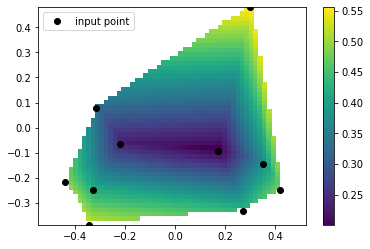

In [ ]:
from scipy.interpolate import NearestNDInterpolator
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()
x = rng.random(10) - 0.5
y = rng.random(10) - 0.5
z = np.hypot(x, y)
X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = LinearNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
plt.pcolormesh(X, Y, Z, shading='auto')
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

In [ ]:
# Tracked (and visible) points
x = [0,2,0,3] 
y = [0,0,3,2]
# Predicted displacement of those points
z = [(0,0), (0,1), (0, 1), (1,1)] 

z_x = [displacement[0] for displacement in z]
z_y = [displacement[1] for displacement in z]

X = [0,1,2,3] # Take linspace of width of the image
Y = [0,1,2,3] # Take linspace of heigth of the image
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

interp_x = LinearNDInterpolator(list(zip(x, y)), z_x) # tracked point -> x-displacement
interp_y = LinearNDInterpolator(list(zip(x, y)), z_y) # tracked point -> y-displacement

# Interpolate the whole 2d grid
Z_X = interp_x(X, Y) 
Z_Y = interp_y(X, Y)

# Interpolated displacements
print(Z_X)
print(Z_Y)

[[0.         0.         0.                nan]
 [0.         0.         0.28571429        nan]
 [0.         0.14285714 0.57142857 1.        ]
 [0.                nan        nan        nan]]
[[0.         0.5        1.                nan]
 [0.33333333 0.83333333 1.                nan]
 [0.66666667 1.         1.         1.        ]
 [1.                nan        nan        nan]]


In [ ]:
# Take displacements of tracked points from the original grid
# 0,0 0,2 2,0 2,2
original_x = np.array([0, 0, 2, 2])
original_y = np.array([0, 2, 0, 2])

print("Original grip position of tracked pixels:",list(zip(original_x, original_y)))

x = original_x + np.array([0,2,0,0])
y = original_y + np.array([0,1,0,1])
print("Predicted coordinates of tracked pixels:", list(zip(x, y)))

# Take RGB values of tracked points
# from the input image take RGB values of original grid points
z = [(0.5,0.6,0.1), (0.,0.,0.), (0, 0.2, 0.2), (0.1, 0.5, 0.6)]
print("RGB values of those points:", z)

z_R = [rgb[0] for rgb in z]
z_G = [rgb[1] for rgb in z]
z_B = [rgb[2] for rgb in z]

X = [0,1,2,3] # Take linspace of width of the image
Y = [0,1,2,3] # Take linspace of heigth of the image
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation


interp_R = NearestNDInterpolator(list(zip(x, y)), z_R) # predicted point coord -> R-intensity
interp_G = NearestNDInterpolator(list(zip(x, y)), z_G) # predicted point coord -> G-intensity
interp_B = NearestNDInterpolator(list(zip(x, y)), z_B) # predicted point coord -> B-intensity

# interpolate the whole 2d grid
Z_R = np.round(interp_R(X, Y), decimals=4) 
Z_G = np.round(interp_G(X, Y), decimals=4)
Z_B = np.round(interp_B(X, Y), decimals=4)

# interpolated displacements
print("Interpolated RGB values:")
print(Z_R)
print(Z_G)
print(Z_B)

Original grip position of tracked pixels: [(0, 0), (0, 2), (2, 0), (2, 2)]
Predicted coordinates of tracked pixels: [(0, 0), (2, 3), (2, 0), (2, 3)]
RGB values of those points: [(0.5, 0.6, 0.1), (0.0, 0.0, 0.0), (0, 0.2, 0.2), (0.1, 0.5, 0.6)]
Interpolated RGB values:
[[0.5 0.5 0.  0. ]
 [0.5 0.5 0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.  0.  0. ]]
[[0.6 0.6 0.2 0.2]
 [0.6 0.6 0.2 0.2]
 [0.6 0.  0.  0. ]
 [0.  0.  0.  0. ]]
[[0.1 0.1 0.2 0.2]
 [0.1 0.1 0.2 0.2]
 [0.1 0.  0.  0. ]
 [0.  0.  0.  0. ]]


## Load data

In [6]:
# Load dataset
TRAIN_DATA = "three_videos_18_frames_2023-02-13"
!unzip -d "$TRAIN_DATA"/ /content/drive/MyDrive/"$TRAIN_DATA".zip # unziping training data

dataset = TaiChiDataset(log_file=TRAIN_DATA+'/sample_ids.txt',
                        root_dir=TRAIN_DATA,
                        check=True,
                        transform=transforms.Compose([
                                              ToTensor()
                        ]))
print(len(dataset))
     

Archive:  /content/drive/MyDrive/three_videos_18_frames_2023-02-13.zip
   creating: three_videos_18_frames_2023-02-13/frame7/
  inflating: three_videos_18_frames_2023-02-13/frame7/-CR4xjdQbkc_824.npy  
  inflating: three_videos_18_frames_2023-02-13/frame7/MGYF1aDwUKg_808.npy  
  inflating: three_videos_18_frames_2023-02-13/frame7/MGYF1aDwUKg_824.npy  
  inflating: three_videos_18_frames_2023-02-13/frame7/vB8XTJfV4rY_792.npy  
  inflating: three_videos_18_frames_2023-02-13/frame7/vB8XTJfV4rY_832.npy  
  inflating: three_videos_18_frames_2023-02-13/frame7/vB8XTJfV4rY_808.npy  
  inflating: three_videos_18_frames_2023-02-13/frame7/-CR4xjdQbkc_816.npy  
  inflating: three_videos_18_frames_2023-02-13/frame7/-CR4xjdQbkc_792.npy  
  inflating: three_videos_18_frames_2023-02-13/frame7/-CR4xjdQbkc_832.npy  
  inflating: three_videos_18_frames_2023-02-13/frame7/MGYF1aDwUKg_832.npy  
  inflating: three_videos_18_frames_2023-02-13/frame7/vB8XTJfV4rY_816.npy  
  inflating: three_videos_18_frames_20

## Get dataset
Later load predictions

In [7]:
# def load_checkpoint(filename):
#   filepath = "/content/drive/MyDrive/checkpoints/"+filename
#   checkpoint = torch.load(filepath)
#   return checkpoint['state_dict']

# model_weights2 = load_checkpoint("checkpoint2_2023-02-14.pth")

# # Set computation device
# device = torch.device('cuda')

# # MODEL INITIALISATION
# model = initialise_model(device, to_learn=['all'])
# model.load_state_dict(model_weights2)
# model.eval()

# DEFINE HYPERPARAMETERS
validation_split = 0 # Validation ratio split
shuffle_dataset = True
random_seed = 42
B = 18 # Batch size

# Get train and validation dataloaders
train_loader, validation_loader = split_dataset(dataset, validation_split, B, shuffle_dataset, random_seed)
dataloaders_dict = {'train': train_loader, 'val': validation_loader}

In [33]:
for i_batch, sample_batched in enumerate(dataloaders_dict['train']):
    batch_size = len(sample_batched['id'])

    input1 = sample_batched['image0']
    input2 = sample_batched['image3']
    last_img = sample_batched['image7']
    inputs = torch.cat((input1, input2), dim=1) 

    # Get ground truth coords and vis
    coords = sample_batched['coords']
    vis = torch.where(sample_batched['vis'] > 0, 1.0, 0.0)
              
    # inputs = inputs.to(device).float() # torch.Size([B, 6, H, W])
    # coords = coords.to(device) # torch.Size([B, 1, 4096, 2])
    # vis = vis.to(device) # torch.Size([B, 1, 4096])
  
    # with torch.no_grad():
    #       # Get model outputs 
    #       outputs = model(inputs) # torch.Size([B, 3, H, W]) same as inputs shape
    #       outputs = outputs['out']
    #       outputs_coords, outputs_vis = get_predictions(outputs, coords, batch_size)

# show_predictions_for_eval(outputs_coords, outputs_vis, coords, vis, input1, last_img)

## Frame reconstructions on ground truth coordinates

In [31]:
def reconstruct_frame(img0, coords, vis, last_img):
  img0=img0.permute(1, 2, 0).numpy() # H, W, C
  last_img=last_img.permute(1, 2, 0).numpy() # H, W, C
  interpolated_img = interpolate(img0, coords, vis)

  plt.imshow(img0)
  plt.title("First Frame")
  plt.show()
  plt.imshow(last_img)
  plt.title("Last Frame")
  plt.show()
  plt.imshow(interpolated_img)
  plt.title("Reconstructed Frame")
  plt.show()

In [45]:
def interpolate(img0, coords, vis):
  # Make original grid
  original_points = get_grid(4096, 1, 360, 640)
  original_points = original_points.view(1, 1, -1, 2).squeeze().flatten().cpu()

  vis = vis.squeeze() > 0

  original_x = original_points[1::2]
  original_y = original_points[::2]

  original_x = original_x[vis]
  original_y = original_y[vis]

  coords = coords.squeeze().cpu().numpy()
  coords = coords
  
  coords_x = coords[:, 0]
  coords_y = coords[:, 1]

  coords_x = coords_x[vis]
  coords_y = coords_y[vis]

  
  # Take RGB values of tracked points
  # from the input image take RGB values of original grid points
  z = img0
  z_R = []
  z_G = []
  z_B = []

  for point in list(zip(original_x, original_y)):
    x, y = point
    x = int(x)
    y = int(y)
    z_R.append(img0[x, y, 0])
    z_G.append(img0[x, y, 1])
    z_B.append(img0[x, y, 2])
  

  X = np.arange(0, 360) # Take linspace of H of the image
  Y = np.arange(0, 640) # Take linspace of W of the image
  X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
  points = list(zip(coords_y, coords_x))

  interp_R = NearestNDInterpolator(points, z_R) # predicted point coord -> R-intensity
  interp_G = NearestNDInterpolator(points, z_G) # predicted point coord -> G-intensity
  interp_B = NearestNDInterpolator(points, z_B) # predicted point coord -> B-intensity

  # interpolate the whole 2d grid
  Z_R = interp_R(X, Y) 
  Z_G = interp_G(X, Y)
  Z_B = interp_B(X, Y)


  concateneted = np.stack([Z_R, Z_G, Z_B])
  concateneted = concateneted.transpose(2, 1, 0) 
  return concateneted

### Results

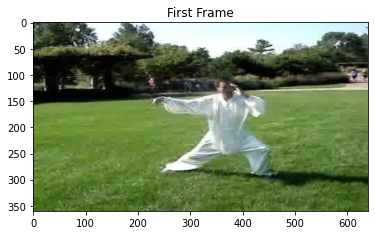

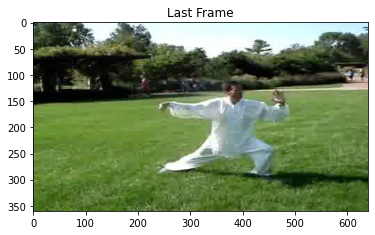

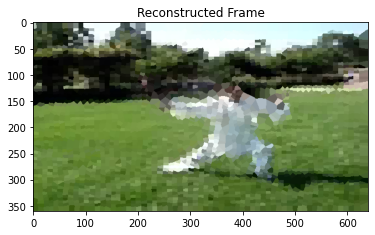

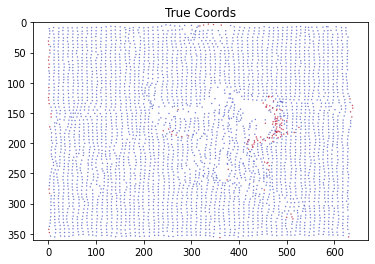

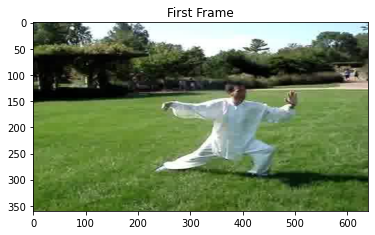

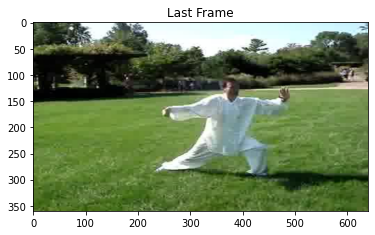

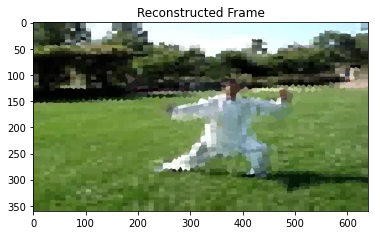

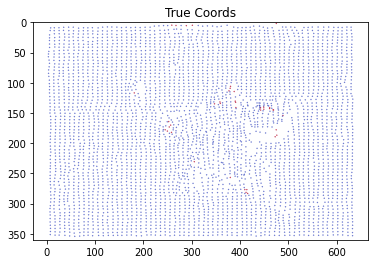

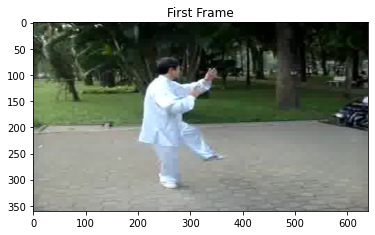

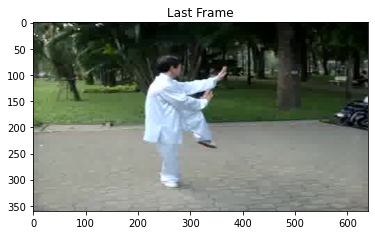

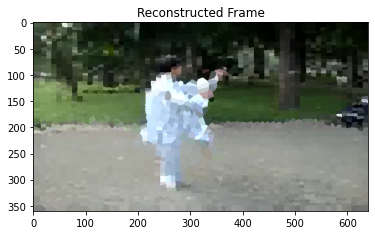

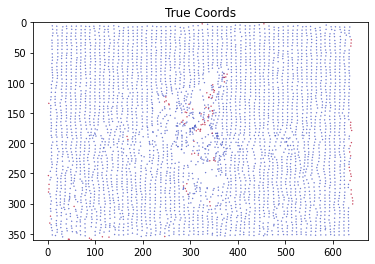

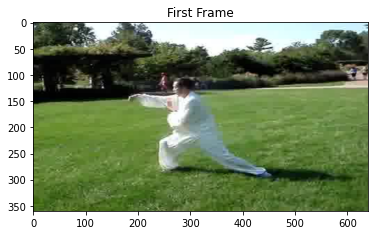

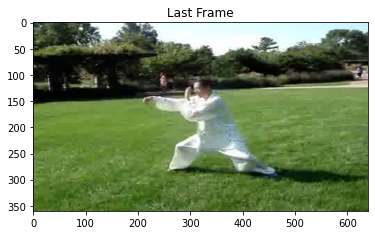

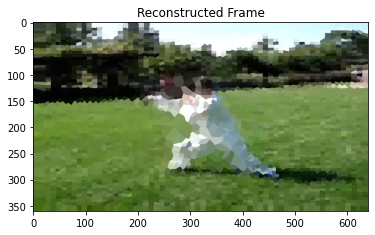

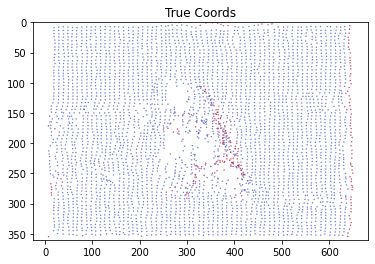

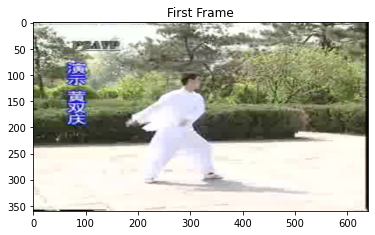

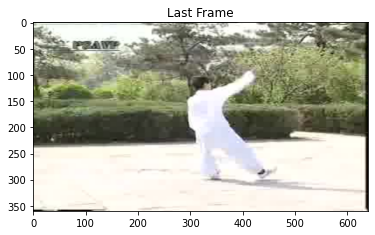

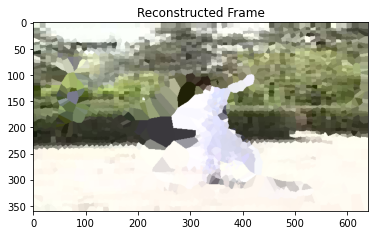

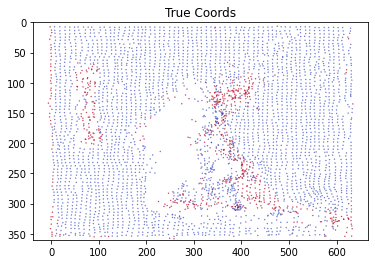

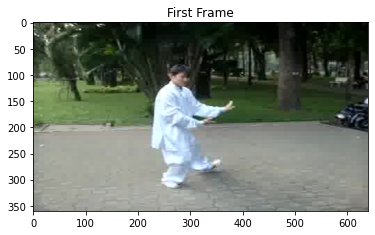

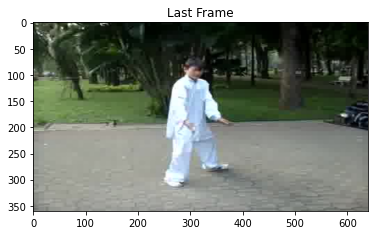

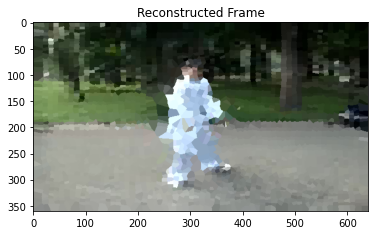

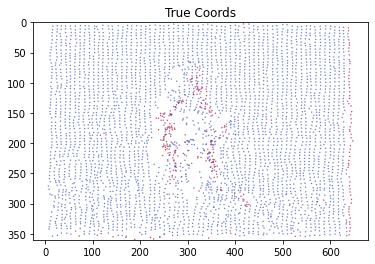

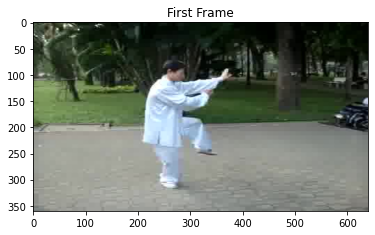

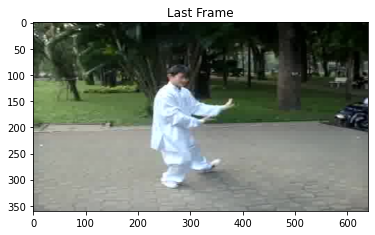

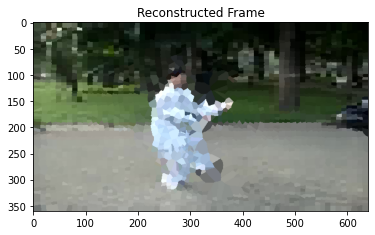

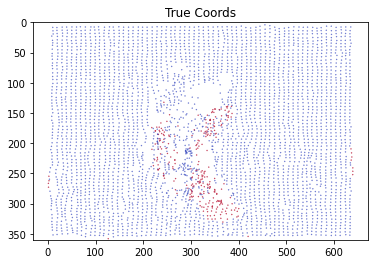

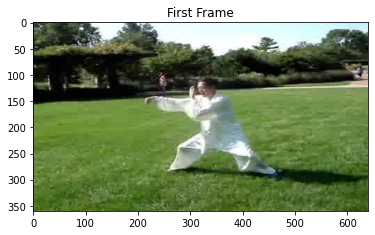

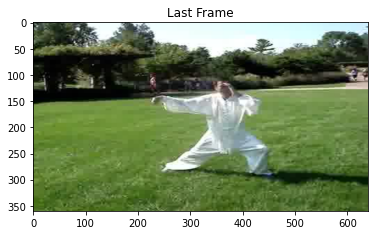

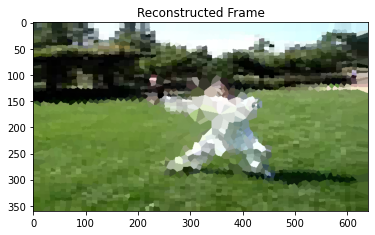

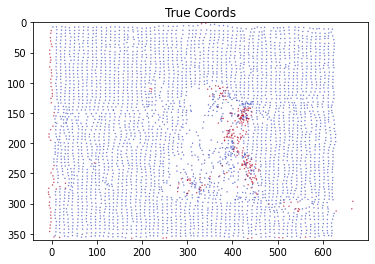

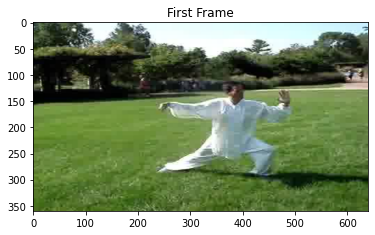

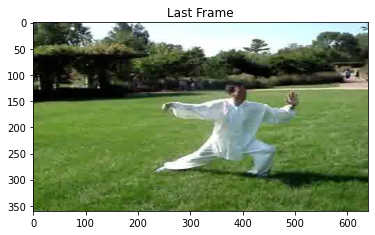

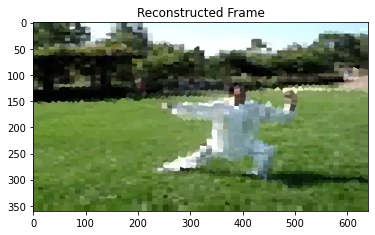

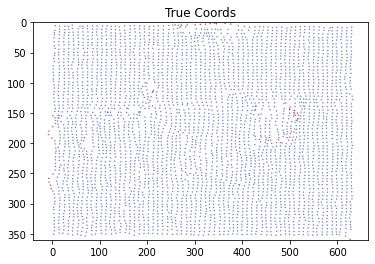

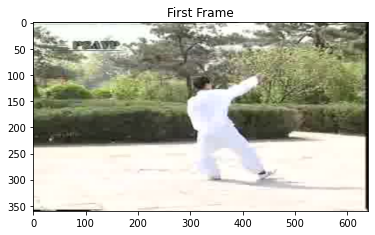

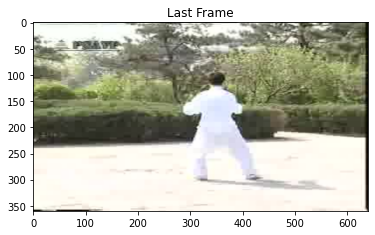

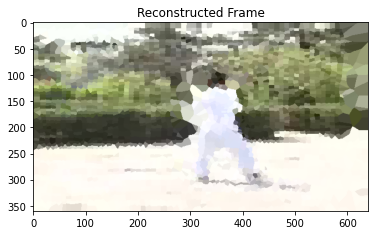

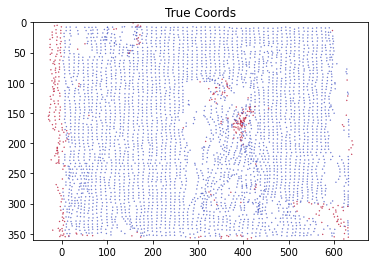

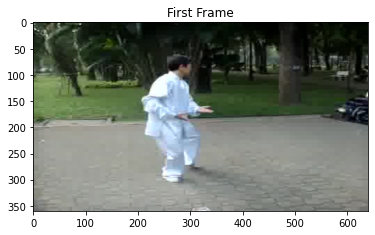

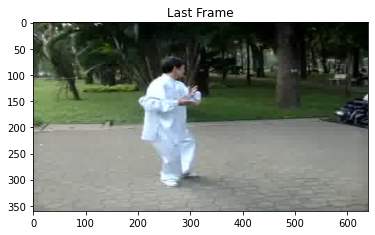

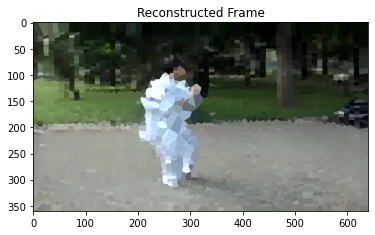

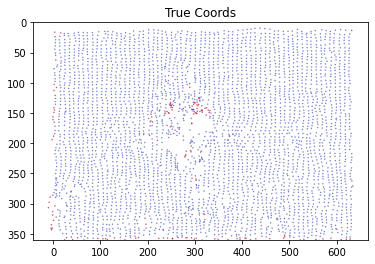

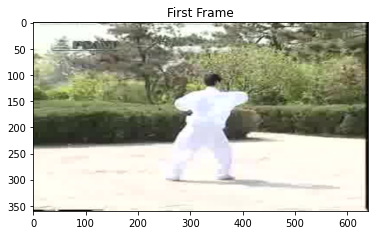

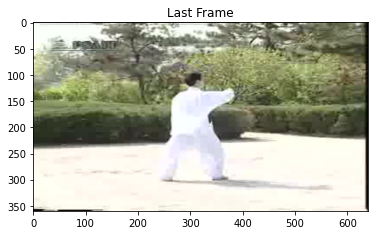

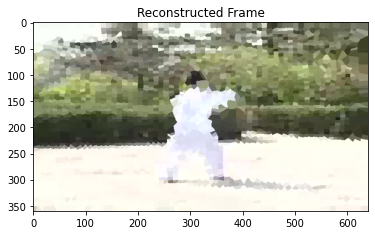

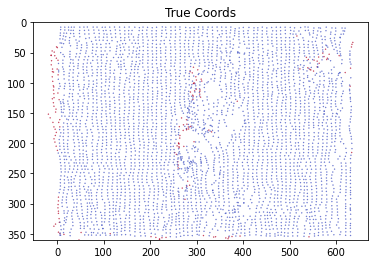

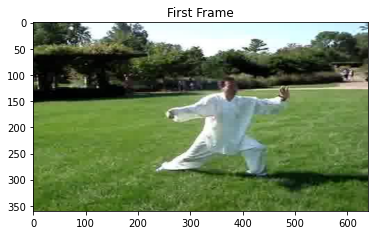

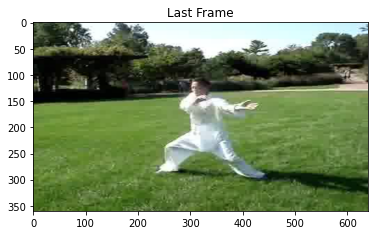

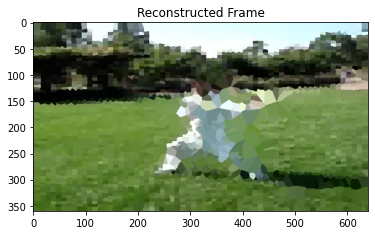

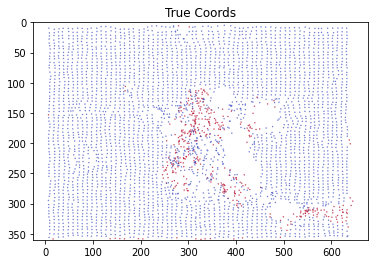

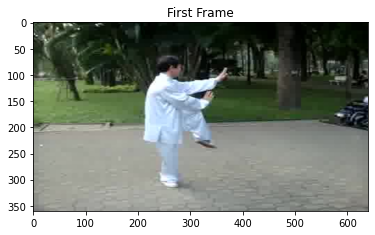

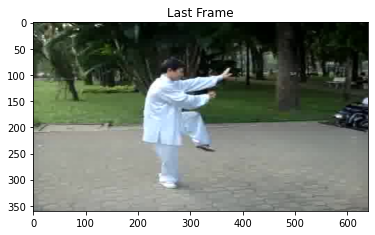

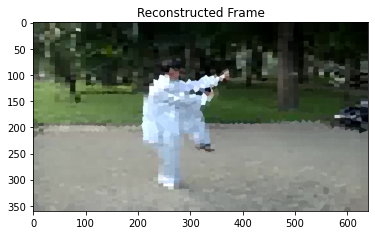

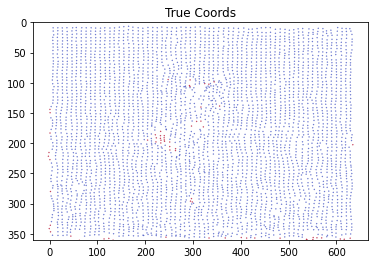

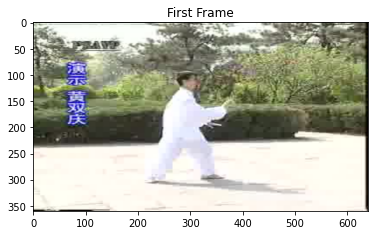

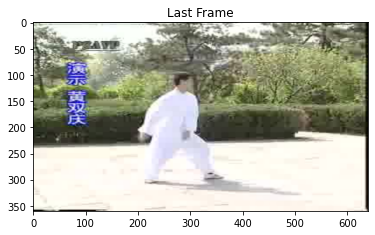

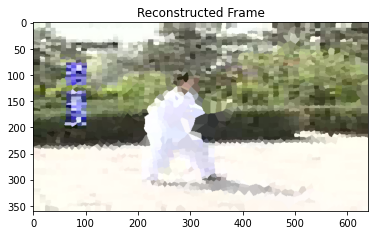

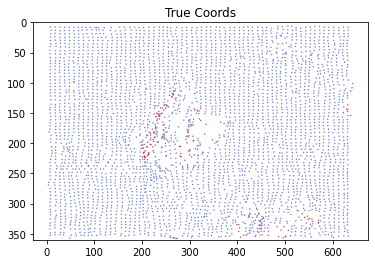

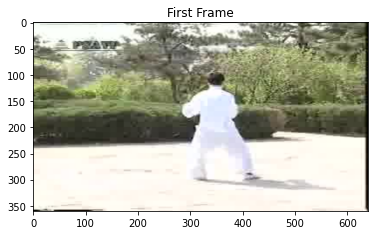

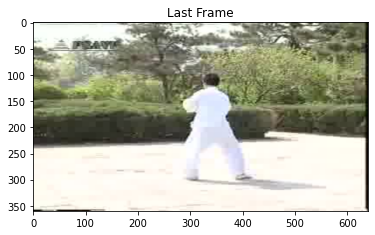

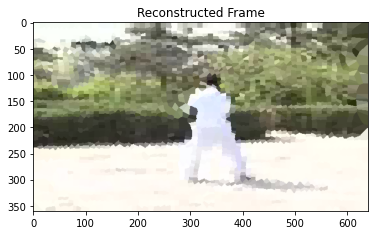

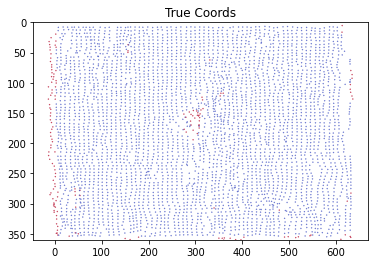

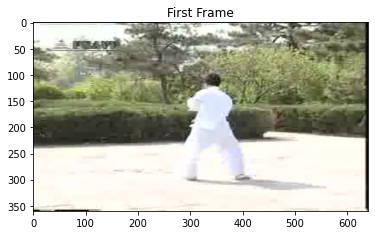

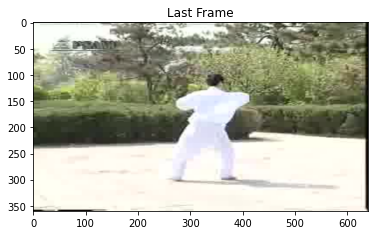

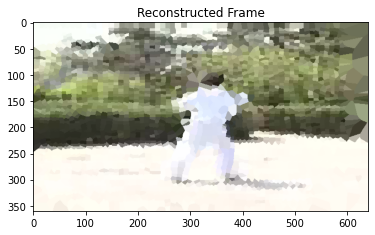

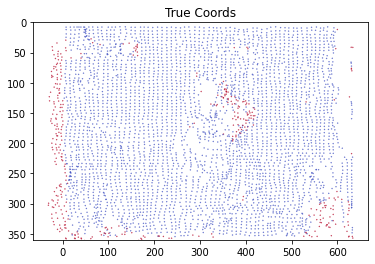

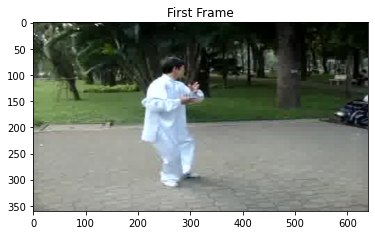

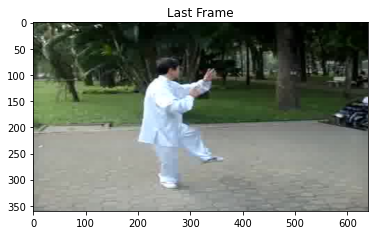

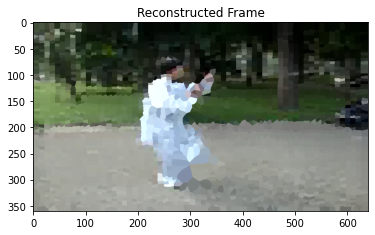

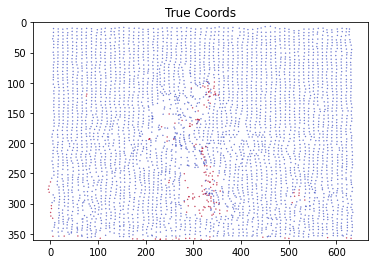

In [49]:
for x in range(0,18):
  reconstruct_frame(input1[x], coords[x], vis[x], last_img[x])
  show_coords(coords[x].squeeze(), vis[x])